In [1]:
%matplotlib widget
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp, solve_bvp
from EOS import NeutronStarEOS
import ode_system
from ode_system import *
from omars_little_helpers import *
import os
apr_eos = NeutronStarEOS('APR')

## 1) Initial conditions

In [2]:
def sample_density(min_rho_c, max_rho_c):
    return np.random.uniform(min_rho_c, max_rho_c)
rho_c = sample_density(4e14, 1.778e16)
#rho_c = sample_density(100, 4e14, 1.778e16)[50]


rho_c = 1.611e+15
[58561] rho_star/rho_crit = 5.690e+02
[58561] Minima do not exist; entering the destabilization regime.


/Users/omar/Research/Axions/pyTOVsolver/ode_system.py:26: RuntimeWarning: invalid value encountered in arcsin
  a_minimum = -np.arcsin(rho_c_over_rho_crit)


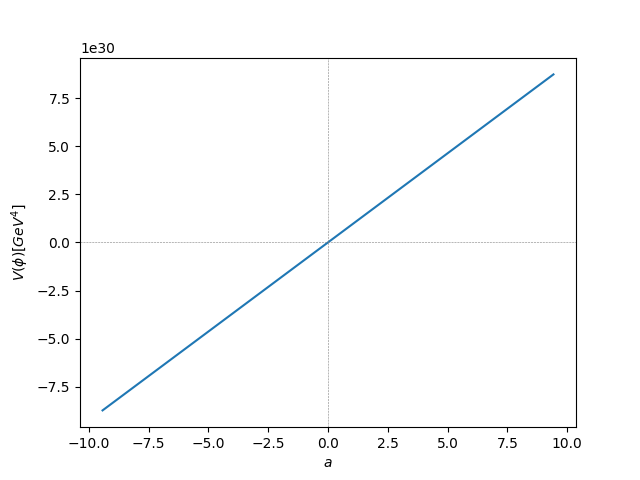

In [3]:
plt.close('all')
rho_c = 1.611e+15
print(f"rho_c = {rho_c:0.3e}")
a_c_best = -2.5
g_s_N = 1e-16
ode_system.mu = (NeutronMass)/(6e-22) * PhiFaGeVToCGs
ode_system.ma = 2.8e-12 * 1e-9 * cmToGeVInv
ode_system.fa = 1e15 * PhiFaGeVToCGs

def axion_potential(a,rho_c):
    V_eff = ode_system.ma**2 * ode_system.fa**2 * (1-np.cos(a)) + (ode_system.fa*a/ode_system.mu)*rho_c*c**2
    return V_eff

a_minimum = axion_initial_guess(rho_c)

a = np.linspace(-3*np.pi, 3*np.pi,1000)

plt.plot(a, axion_potential(a, rho_c));
plt.xlabel(r'$a$')
plt.axhline(y=0, linestyle='--', color='grey', linewidth=0.4)
plt.axvline(x=0, linestyle='--', color='grey', linewidth=0.4)
plt.ylabel(r"$V(\phi)[GeV^4]$");
plt.show()

In [222]:
# Define the domain for r
r_center = 1e-15
r_rad = 3e6 

initial_conditions = create_boundary_conditions(eos_class=apr_eos,
    rho_c=rho_c,
    nu_c=1,
    lambda_c=0,
    a_c=a_c_best,
    ri=r_center
)

In [223]:
# the system need to be wrapped since solve_ivp expects the ode
# function to be only function of (independent, dependent) variables
def inside_ivp_wrapper(r, y):
    P = apr_eos.get_pressure(extrapolate=True)
    dPdRho = apr_eos.dP_dRho()
    return inside_ivp_system(r, y, P, dPdRho)

## 2) Interior: solve_ivp to get R

In [224]:
def solve_interior(initial_conditions):
    # Solve the ivp
    sol = solve_ivp(inside_ivp_wrapper, [r_center,r_rad], initial_conditions, method='LSODA', events=[stop_at_small_r_step])

      # Extract boundary conditions at R from the interior solution
    a_in = sol.y[0, :]  # a at the surface
    a_prime_in = sol.y[1, :]  # a' at the surface
    nu_in = sol.y[2, :]
    llambda_in = sol.y[3, :]
    rho = sol.y[4, :]
    r_inside = sol.t
    # Process the solution
    # Check if the solution is successful and process it
    if sol.success:
        print(f" IVP Solution found!")
        print("     ", sol.message)
    if sol.t_events[0].size > 0:
        event_message = sol.t_events[0][0]  # Get the message of the triggered event
        print(f"Event triggered: {event_message/1e5:0.4} km")
        radius = sol.t_events[0][0]
    else:
        print(f" Warning: No events were triggered. Setting default radius value.")
        idx_outside = np.argmin(rho)
        print(f" Radius detected at rho = {rho[idx_outside]} g/cm^3 and R = {r_inside[idx_outside]/1e5} km")
        radius = r_inside[idx_outside]
    return sol
sol = solve_interior(initial_conditions)

 IVP Solution found!
      A termination event occurred.
Event triggered: 10.94 km


In [225]:
r_inside = sol.t  # to avoid taking a negative density use [:-1]
a, a_prime, nu, llambda, rho= sol.y[:,:]
idx_outside = np.argmin(rho)
radius_ns = r_inside[idx_outside]
#mass_ns = mass_values[idx_outside]
print(f"The star has radius = {radius_ns/1e5:0.4} km at density = {rho[idx_outside]:0.4} g/cm^(3)")

The star has radius = 10.94 km at density = 1.744 g/cm^(3)


In [226]:
len(rho)

187

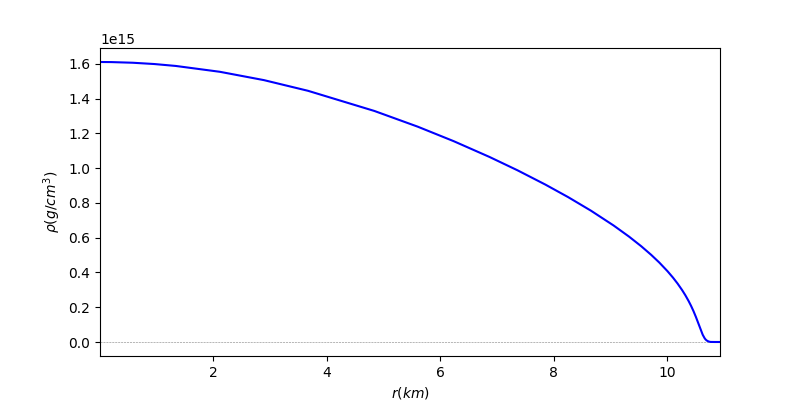

In [227]:
%matplotlib widget
plot_something(r_inside, rho, y_label=r"$\rho (g/cm^3)$", radius=radius_ns, debug=True)

## 3) Outside System Relaxation

In [228]:
################# B.C. for outside system ################# 
def create_outside_bc(a_R, a_prime_R, nu_R, llambda_R):
    def outside_conditions(ya, yb):
        return np.array([
            ya[0] - a_R,                 #  ya[1] a_prime(ri) = 0
            yb[1],                 #  yb[1] a_prime(rf) = 0
            ya[2] - nu_R,    # nu(ri) = nu_initial
            ya[3] - llambda_R, # lambda(ri) = lambda_initial
        ])
    return outside_conditions

In [229]:
# B.C. for the outside system from the endpoint of the interior solution
a_prime_R = a_prime[-1]
a_R = a[-1]
nu_R = nu[-1]
llambda_R = llambda[-1]
outside_bc_func = create_outside_bc(a_R, a_prime_R, nu_R, llambda_R)

# Define the domain for r
radius = r_inside[-1]
r_far = 2e8
r_outside = create_r_mesh(radius,r_far,4000)


y_initial = np.zeros((4, r_outside.size))  # Initialize the array with zeros
y_initial[0, :] = np.linspace(a_R, 0, len(r_outside))
# linearly interpolate the remaining values of a(r) from ac to final_value_a
y_initial[1, :] = np.linspace(a_prime_R, 0, len(r_outside))  # a_prime(r)
y_initial[2, :] = nu_R  # nu(r)
y_initial[3, :] = llambda_R  # llambda(r)
# rho should be constant for a long distance and then decreases right before the radius

In [230]:
def solve_bvp_outside(r_outside, y_initial, outside_bc_func, initial_tol):
    print(f"[{os.getpid()}] Solving the exterior....")
    tol = initial_tol  # Initialize the tolerance
    while tol<=1.:
        sol = solve_bvp(outside_bvp_system, outside_bc_func, r_outside, y_initial, max_nodes=1000000, tol=tol)
        # store the solution
        a_out = sol.sol(r_outside)[0]
        a_prime_out = sol.sol(r_outside)[1]
        nu_out = sol.sol(r_outside)[2]
        llambda_out = sol.sol(r_outside)[3]
    
        # Check if the solution is successful
        if sol.success:
            print(f"[{os.getpid()}] BVP Solution found with tol = {tol}!")
            return sol, a_out, a_prime_out, nu_out, llambda_out
        else:
            print(f"[{os.getpid()}] Solution was not successful with tolerance {tol}. Retrying with higher tolerance.")
            tol *= 10  # Increase the tolerance by an order of magnitude
    print(f"[{os.getpid()}] Exceeded maximum tolerance. Solution not found.")
    return None, None, None, None, None


In [231]:
sol_out, a_out, a_prime_out, nu_out, llambda_out = solve_bvp_outside(r_outside, y_initial, outside_bc_func, initial_tol=1e-14)

[57800] Solving the exterior....


/usr/local/lib/python3.11/site-packages/scipy/integrate/_bvp.py:1028: UserWarning: `tol` is too low, setting to 2.22e-14
  warn(f"`tol` is too low, setting to {100 * EPS:.2e}")


[57800] BVP Solution found with tol = 1e-14!


mass = 2.0313567177632255


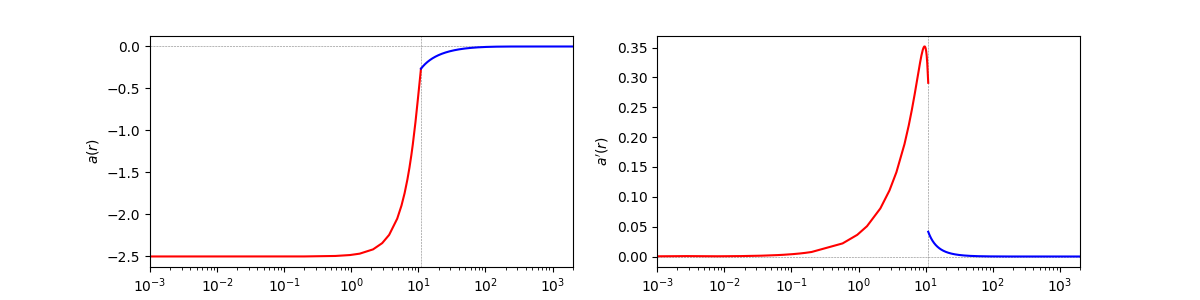

In [232]:
# set the figure size large enough to accommodate two side-by-side plots
plt.figure(figsize=(12, 3))  
mass = c**2 * r_outside[-1] / (2*G) * (1. - np.exp(-llambda_out[-1]))/Msun
print(f"mass = {mass}")

plot_full_side_by_side(r_inside, r_outside, radius, a, a_out, 'a(r)', subplot_index=1)
plot_full_side_by_side(r_inside, r_outside, radius, a_prime*1e5, a_prime_out*1e5, 'a\'(r)', subplot_index=2)
plt.savefig("ac_min_sol.pdf")
plt.show()


In [12]:
from scipy.optimize import minimize
optimized_sol = {}
def continuity_cost(a_initial_guess):
    global optimized_sol
    # Initial tolerance value for solve_bvp
    initial_tol = 1e-14
    # Step 1: Solve the interior problem with the current guess for a_initial
    a_initial_guess = a_initial_guess[0]
    print(f"Initial guess: {a_initial_guess}")

    initial_conditions = create_boundary_conditions(eos_class=apr_eos,
        rho_c=rho_c,
        nu_c=1,
        lambda_c=0,
        a_c=a_initial_guess,
        ri=r_center 
    )
    sol_interior, a_in, a_prime_in, nu_in, llambda_in, rho, radius = solve_interior(initial_conditions)
    if not sol_interior.success:
        return np.inf  # Penalize failed solutions heavily
    
    # Extract boundary conditions at R from the interior solution
    a_R = a_in[-1]  # a at the surface
    a_prime_R = a_prime_in[-1]  # a' at the surface
    nu_R = nu_in[-1]
    llambda_R = llambda_in[-1]

    # create the mesh for the BVP outside
    r_far = 2e8
    r_outside = create_r_mesh(radius,r_far,4000)
    # Update the boundary conditions for the exterior problem
    outside_bc_func = create_outside_bc(a_R, a_prime_R, nu_R, llambda_R)
    
    # gues initial solution
    y_initial = np.zeros((4, r_outside.size))  # Initialize the array with zeros
    y_initial[0, :] = np.linspace(a_R, 0, len(r_outside))
    # linearly interpolate the remaining values of a(r) from ac to final_value_a
    y_initial[1, :] = np.linspace(a_prime_R, 0, len(r_outside))  # a_prime(r)
    y_initial[2, :] = nu_R  # nu(r)
    y_initial[3, :] = llambda_R  # llambda(r)
    
    # Step 2: Solve the exterior problem with these boundary conditions
    sol_exterior, a_out, a_prime_out, nu_out, llambda_out = solve_bvp_outside(r_outside, y_initial, outside_bc_func, initial_tol)
    if not sol_exterior.success:
        return np.inf  # Penalize failed solutions heavily
    mass = c**2 * r_outside[-1] / (2*G) * (1. - np.exp(-llambda_out[-1]))/Msun

    optimized_sol = {
    "a_c": a_initial_guess, "radius": radius, "mass": mass, "rho": rho, "a_in": a_in, "a_out": a_out, "a_prime_in": a_prime_in, "a_prime_out": a_prime_out,
    "nu_in": nu_in, "nu_out": nu_out, "llambda_in": llambda_in, "llambda_out": llambda_out, 
    "r_inside": sol_interior.t, "r_outside": r_outside
    }
    # Compute the cost: Here, we aim for a smooth transition, so ideally, a_out[0] - a_R should be close to 0
    # and a_prime_out[0] - a_prime_R should be close to 0. Adjust the cost function as needed.
    cost_a = (a_out[0] - a_R)**2   # Simple squared difference
    cost_a_prime = (a_prime_out[0] - a_prime_R)**2
    print(f"Cost for a_R = {cost_a:0.3e}")
    print(f"Cost for a_prime_R = {cost_a:0.3e}")
    cost = cost_a+cost_a_prime
    
    return cost 

# Initial guess for a_initial
a_initial_guess = -0.01067754565061467 #initial_conditions[0]  # Use the a_initial you calculated earlier as the starting point

# Perform the optimization
result = minimize(continuity_cost, a_initial_guess, method='Nelder-Mead', options={'maxiter': 100, 'xatol': 1e-9})

if result.success:
    optimized_a_initial = result.x[0]
    print(f"Optimized a_initial: {optimized_a_initial}")
else:
    print("Optimization was not successful. Try adjusting the initial guess or method.")


Initial guess: -0.01067754565061467
IVP Solution found!
A termination event occurred.
Solving the exterior....


/usr/local/lib/python3.11/site-packages/scipy/integrate/_bvp.py:1028: UserWarning: `tol` is too low, setting to 2.22e-14
  warn(f"`tol` is too low, setting to {100 * EPS:.2e}")
/Users/omar/Research/Axions/pyTOVsolver/ode_system.py:177: RuntimeWarning: overflow encountered in exp
  expression_for_metric_pot = -1/r + np.exp(llambda)/r  - \
/Users/omar/Research/Axions/pyTOVsolver/ode_system.py:178: RuntimeWarning: overflow encountered in exp
  (8 * np.exp(llambda) * fa * G * np.pi * r * (-fa * ma**2  * (-1 + np.cos(a))))/(c**4 ) + \
/Users/omar/Research/Axions/pyTOVsolver/ode_system.py:177: RuntimeWarning: invalid value encountered in subtract
  expression_for_metric_pot = -1/r + np.exp(llambda)/r  - \
/Users/omar/Research/Axions/pyTOVsolver/ode_system.py:184: RuntimeWarning: overflow encountered in exp
  expression_for_mass = 1/r - np.exp(llambda)/r  + \
/Users/omar/Research/Axions/pyTOVsolver/ode_system.py:185: RuntimeWarning: overflow encountered in exp
  (8 * np.exp(llambda) * fa * G 

 Solution was not successful with tolerance 1e-14. Retrying with higher tolerance.
 Solution was not successful with tolerance 1e-13. Retrying with higher tolerance.
 Solution was not successful with tolerance 1e-12. Retrying with higher tolerance.
 Solution was not successful with tolerance 1e-11. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999999e-11. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999999e-10. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999999e-09. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999998e-08. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999997e-07. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999997e-06. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999998e-05. Retryin

/usr/local/lib/python3.11/site-packages/scipy/integrate/_bvp.py:40: RuntimeWarning: invalid value encountered in subtract
  df_dy[:, i, :] = (f_new - f0) / hi
/usr/local/lib/python3.11/site-packages/scipy/integrate/_bvp.py:566: RuntimeWarning: invalid value encountered in divide
  r_middle /= 1 + np.abs(f_middle)


 Solution was not successful with tolerance 9.999999999999997e-06. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999998e-05. Retrying with higher tolerance.
 Solution was not successful with tolerance 0.0009999999999999998. Retrying with higher tolerance.
 BVP Solution found with tol = 0.009999999999999998!
Cost for a_R = 5.049e-29
Cost for a_prime_R = 5.049e-29
Initial guess: -0.010143668368083936
IVP Solution found!
A termination event occurred.
Solving the exterior....
 Solution was not successful with tolerance 1e-14. Retrying with higher tolerance.
 Solution was not successful with tolerance 1e-13. Retrying with higher tolerance.
 Solution was not successful with tolerance 1e-12. Retrying with higher tolerance.
 Solution was not successful with tolerance 1e-11. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999999e-11. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.99999

/usr/local/lib/python3.11/site-packages/scipy/integrate/_bvp.py:567: RuntimeWarning: invalid value encountered in divide
  r1 /= 1 + np.abs(f1)
/usr/local/lib/python3.11/site-packages/scipy/integrate/_bvp.py:568: RuntimeWarning: invalid value encountered in divide
  r2 /= 1 + np.abs(f2)


 Solution was not successful with tolerance 1e-14. Retrying with higher tolerance.
 Solution was not successful with tolerance 1e-13. Retrying with higher tolerance.
 Solution was not successful with tolerance 1e-12. Retrying with higher tolerance.
 Solution was not successful with tolerance 1e-11. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999999e-11. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999999e-10. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999999e-09. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999998e-08. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999997e-07. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999997e-06. Retrying with higher tolerance.
 Solution was not successful with tolerance 9.999999999999998e-05. Retryin

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py", line 154, in fun
    return self.fun_single(t, y)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py", line 23, in fun_wrapped
    return np.asarray(fun(t, y), dtype=dtype)
                      ^^^^^^^^^
  File "/var/folders/wn/k16m1d894ng_58sbvv687rhm0000gn/T/ipykernel_38459/2062542519.py", line 4, in inside_ivp_wrapper
  File "/Users/omar/Research/Axions/pyTOVsolver/EOS.py", line 87, in get_pressure
    log_pres = self.eq_of_state(self.default_xi)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/omar/Research/Axions/pyTOVsolver/EOS.py", line 71, in eq_of_state
    term3 = (self.a11 + self.a12

: 

In [29]:
# Step 1: Solve the interior problem with the current guess for a_initial

def full_solve(a_c, rho_c):

  # Initial tolerance value
  initial_tol = 1e-14

  initial_conditions = create_boundary_conditions(eos_class=apr_eos,
    rho_c=rho_c,
    nu_c=1,
    lambda_c=0,
    a_c=a_c,
    ri=r_center 
  )
  sol_interior, a_in, a_prime_in, nu_in, llambda_in, rho, radius = solve_interior(initial_conditions)

  # Extract boundary conditions at R from the interior solution
  a_R = a_in[-1]  # a at the surface
  a_prime_R = a_prime_in[-1]  # a' at the surface
  nu_R = nu_in[-1]
  llambda_R = llambda_in[-1]
  
  # mesh for outside solution
  r_far = 2e8
  r_outside = create_r_mesh(radius,r_far,4000)
  # Update the boundary conditions for the exterior problem
  outside_bc_func = create_outside_bc(a_R, a_prime_R, nu_R, llambda_R)

  # gues initial solution
  y_initial = np.zeros((4, r_outside.size))  # Initialize the array with zeros
  y_initial[0, :] = np.linspace(a_R, 0, len(r_outside))
  # linearly interpolate the remaining values of a(r) from ac to final_value_a
  y_initial[1, :] = np.linspace(a_prime_R, 0, len(r_outside))  # a_prime(r)
  y_initial[2, :] = nu_R  # nu(r)
  y_initial[3, :] = llambda_R  # llambda(r)
  # Step 2: Solve the exterior problem with these boundary conditions
  sol_exterior, a_out, a_prime_out, nu_out, llambda_out = solve_bvp_outside(r_outside, y_initial, outside_bc_func, initial_tol)

  results = {
    "a_c": a_c, "radius": radius, "rho": rho, "a_in": a_in, "a_out": a_out, "a_prime_in": a_prime_in, "a_prime_out": a_prime_out,
    "nu_in": nu_in, "nu_out": nu_out, "llambda_in": llambda_in, "llambda_out": llambda_out, 
    "r_inside": sol_interior.t, "r_outside": r_outside
}

  return results

In [31]:
results_dict = full_solve(bestfit, rho_c)

IVP Solution found!
A termination event occurred.
BVP Solution found!


/usr/local/lib/python3.11/site-packages/scipy/integrate/_bvp.py:1028: UserWarning: `tol` is too low, setting to 2.22e-14
  warn(f"`tol` is too low, setting to {100 * EPS:.2e}")


In [32]:
mass = c**2 * results_dict["r_outside"][-1] / (2*G) * (1. - np.exp(-results_dict["llambda_out"][-1]))/Msun
print(f"The star of rho = {rho_c:0.3e} g/cm^3 has M/Msun = {mass:0.5} and R = {radius/1e5:0.5} km")

The star of rho = 1.000e+15 g/cm^3 has M/Msun = 1.4257 and R = 11.435 km


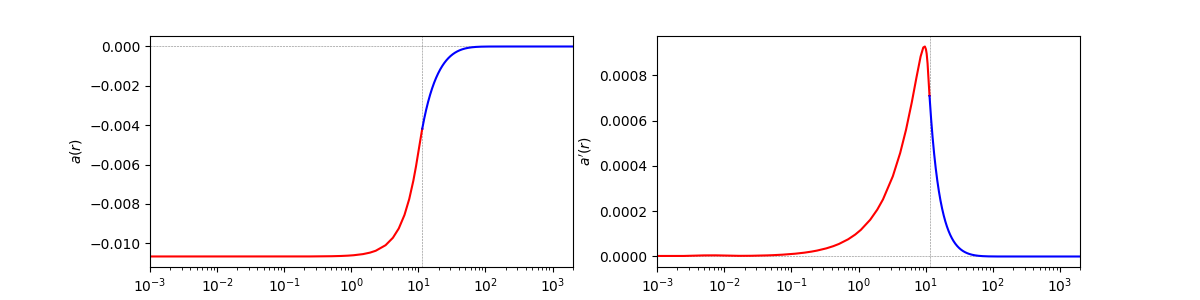

In [33]:
plt.close('all')
# set the figure size large enough to accommodate two side-by-side plots
plt.figure(figsize=(12, 3))  

plot_full_side_by_side(results_dict["r_inside"], results_dict["r_outside"], results_dict["radius"], results_dict["a_in"], results_dict["a_out"], 'a(r)', subplot_index=1)
plot_full_side_by_side(results_dict["r_inside"], results_dict["r_outside"], results_dict["radius"], results_dict["a_prime_in"]*1e5, results_dict["a_prime_out"]*1e5, 'a\'(r)', subplot_index=2)

plt.savefig("optimized_ac.pdf")
plt.show()

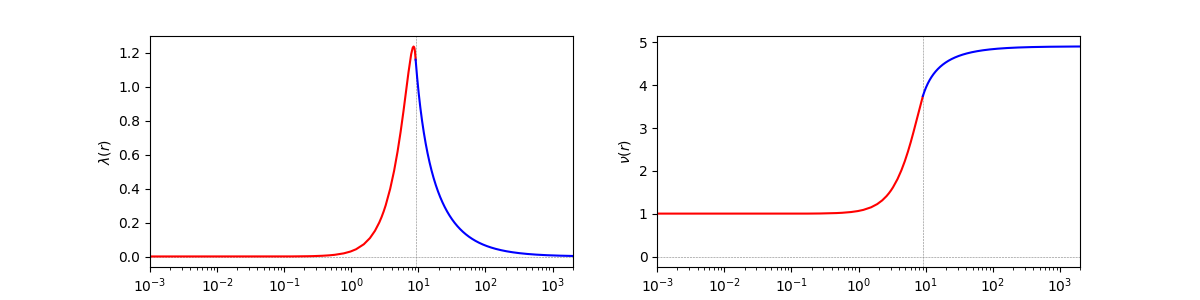

In [21]:
plt.close('all')
# set the figure size large enough to accommodate two side-by-side plots
plt.figure(figsize=(12, 3))  

plot_full_side_by_side(r_inside, r_outside, radius, llambda_in, llambda_out, "\lambda(r)", subplot_index=1)
plot_full_side_by_side(r_inside, r_outside, radius, nu_in, nu_out, "\\nu(r)", subplot_index=2)

plt.show()